In [1]:
import re
import nltk
import string
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
from nltk.corpus import stopwords
from keras.models import Sequential
from nltk import wordpunct_tokenize
from keras.models import load_model
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nltk.download('punkt')
nltk.download('omw')
nltk.download('wordnet')
nltk.download('stopwords')

review_col = "review_description"
rating_col = "rating"


df = pd.read_excel('train.xlsx')

print(df.head(10))

stopwords_list_arabic = stopwords.words('arabic')
# stopwords_list_english = stopwords.words('english')
print(stopwords_list_arabic,'\n')


2023-12-19 03:24:15.150247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 03:24:15.150277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 03:24:15.151413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 03:24:15.163970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 03:24:16.465749: W tensorflow/compiler/tf2

Num GPUs Available:  1


[nltk_data] Downloading package punkt to /home/hazem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw to /home/hazem/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hazem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hazem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                  review_description  rating
0  شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...      -1
1  خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...       1
2  تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...      -1
3  فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...       1
4  سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...      -1
5  قعد عشرين سنة يدور على سائق بس اما عن توصيل ال...       0
6                                         احلئ تطبيق       1
7                                      رائع واو مدهش       1
8  مکو بس البحرین وعمان وغیرهه بس العراق مکو یعنی...      -1
9                    تطبيق جميل يستاهل الخمس نجوم👍👍👍       1
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آ

In [2]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)


def remove_emojis(text):
  return ''.join(c for c in text if not unicodedata.combining(c))

def is_english_word(word) :
    alpha = "abcdefghijklmnopqrtuvwxyz"
    for i in word:
        if i in alpha :
            return True
    return False


def remove_punctuations(word):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return word.translate(translator)



def preprocess_review(sentence):
    sentence = str(sentence)
    words = wordpunct_tokenize(sentence)
    non_english_words = [word for word in words if not is_english_word(word)]
    cleaned_sentence = ' '.join(non_english_words)
    
    cleaned_sentence = remove_emojis(cleaned_sentence)
    cleaned_sentence = normalize_arabic(cleaned_sentence)
    cleaned_sentence = remove_repeating_char(cleaned_sentence)
    cleaned_sentence = remove_punctuations(cleaned_sentence)
    
    return cleaned_sentence

def preprocess_dataframe(df, review_col=review_col):
    tokenizer = RegexpTokenizer(r'\w+')
    df[review_col] = df[review_col].apply(preprocess_review)

    df[review_col] = df[review_col].apply(tokenizer.tokenize)

    df[review_col] = df[review_col].apply(lambda x: [item for item in x if item not in stopwords_list_arabic])

    arabic_stemmer = ISRIStemmer()
    df[review_col] = df[review_col].apply(lambda x: [arabic_stemmer.stem(word) for word in x])

In [3]:
# print(df.head(30))
preprocess_dataframe(df);
print(df.head(30))


                                   review_description  rating
0   [شرك, زبل, سوق, رشم, فيش, حتي, رقم, شكو, سوق, ...      -1
1   [خدم, دفع, طرق, الك, نت, وقف, عند, اصبح, فقط, ...       1
2   [طبق, غبي, جري, حذف, عمل, كود, خصم, خدم, كتر, ...      -1
3   [فعل, طبق, تاز, مكن, يتح, خدم, طبق, ان, تطع, ت...       1
4            [سيء, جدا, سعر, رسم, وصل, تمت, لقع, صله]      -1
5   [قعد, سنه, يدر, علي, سئق, اما, وصل, شيء, جيد, ...       0
6                                          [حلئ, طبق]       1
7                                          [رئع, دهش]       1
8   [مکو, حری, وعم, غیر, عرق, مکو, یعنی, نجم, وحد,...      -1
9                           [طبق, جمل, تهل, خمس, نجم]       1
10                                              [طلب]       1
11                               [سمر, عمر, ريق, مصر]       1
12  [تاز, صدق, ودق, سرع, وصل, رجء, وضع, تقم, علي, ...       1
13                                   [هالبرنامج, نقذ]       1
14                     [مره, سرع, جني, طلب, نصح, صرح]       1
15      

Length of 'positive' column Before: 19189
Length of 'negative' column Before: 11340
Length of 'neutral' column Before: 1507
100795 total words in positive, with a vocabulary size of 6769


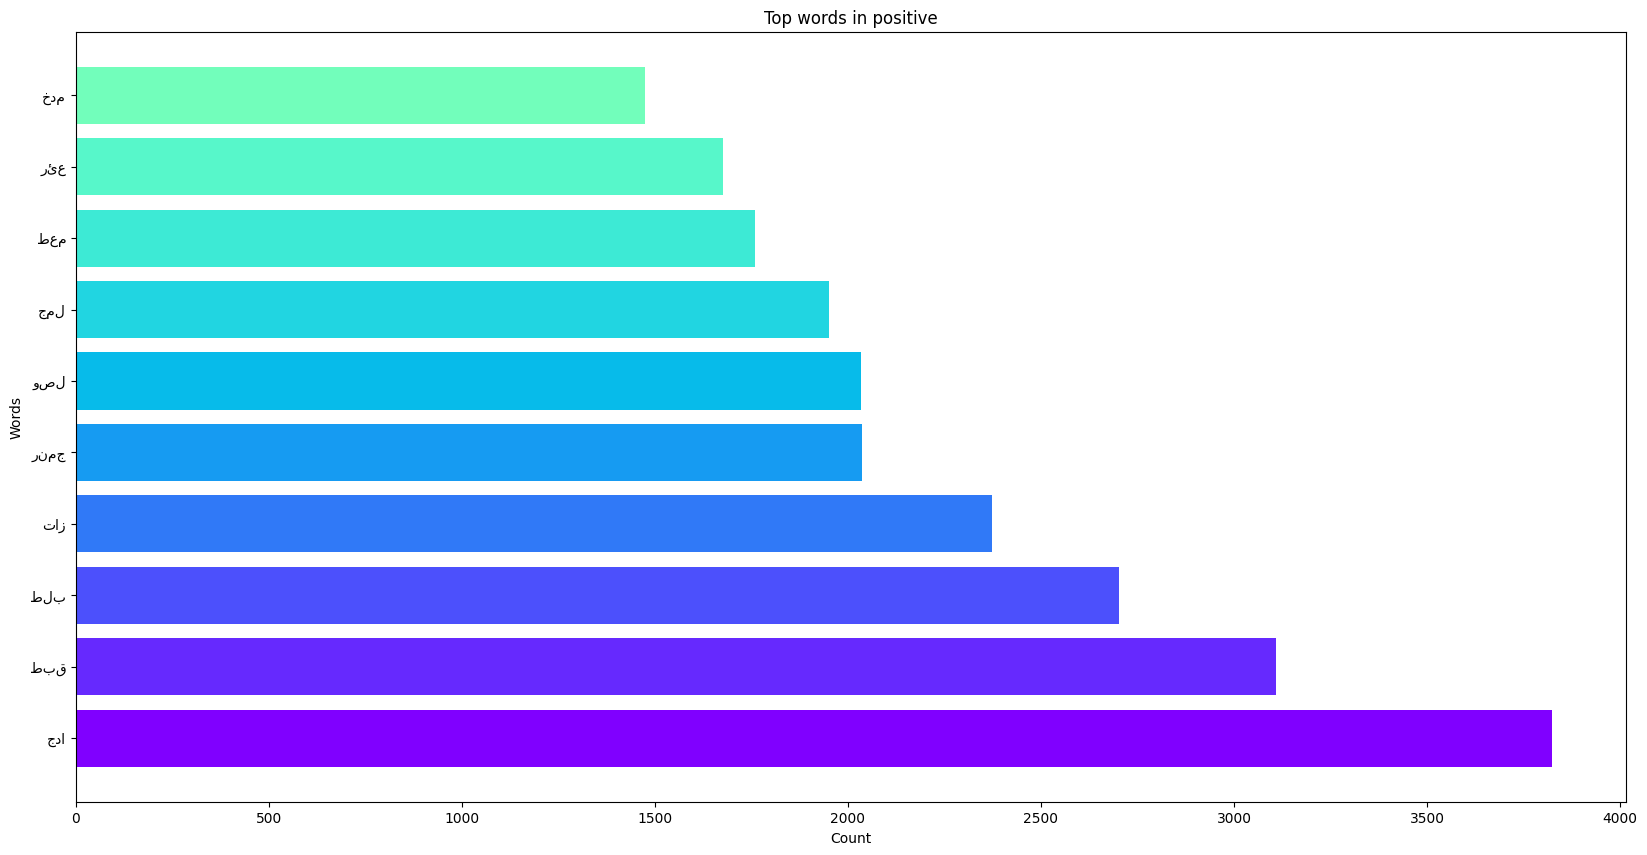

13881 total words in neutral, with a vocabulary size of 2389


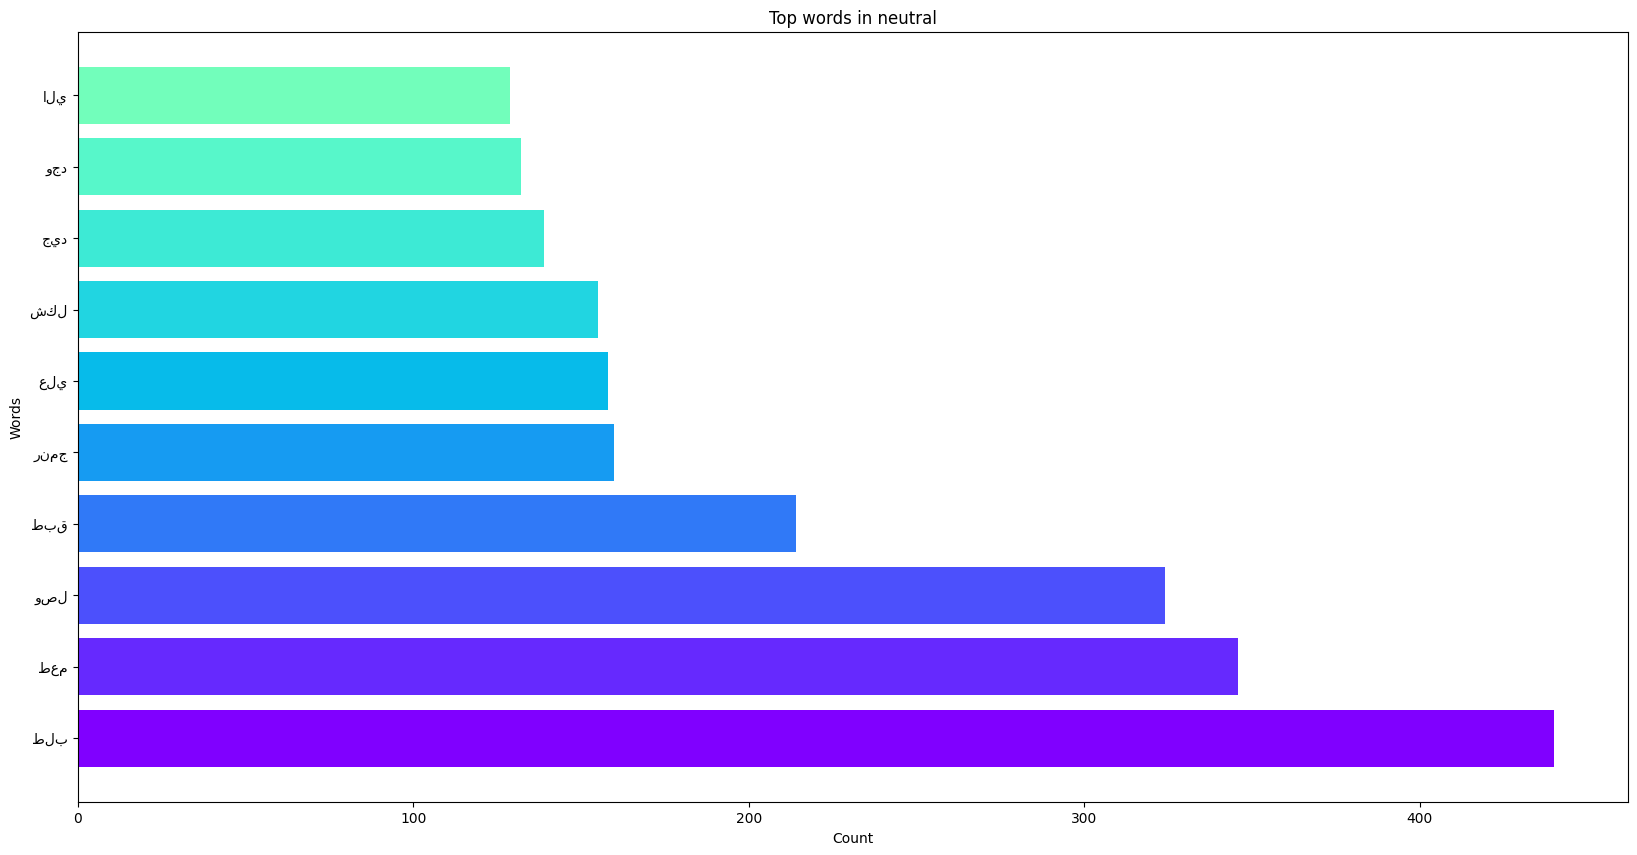

132033 total words in negative, with a vocabulary size of 7645


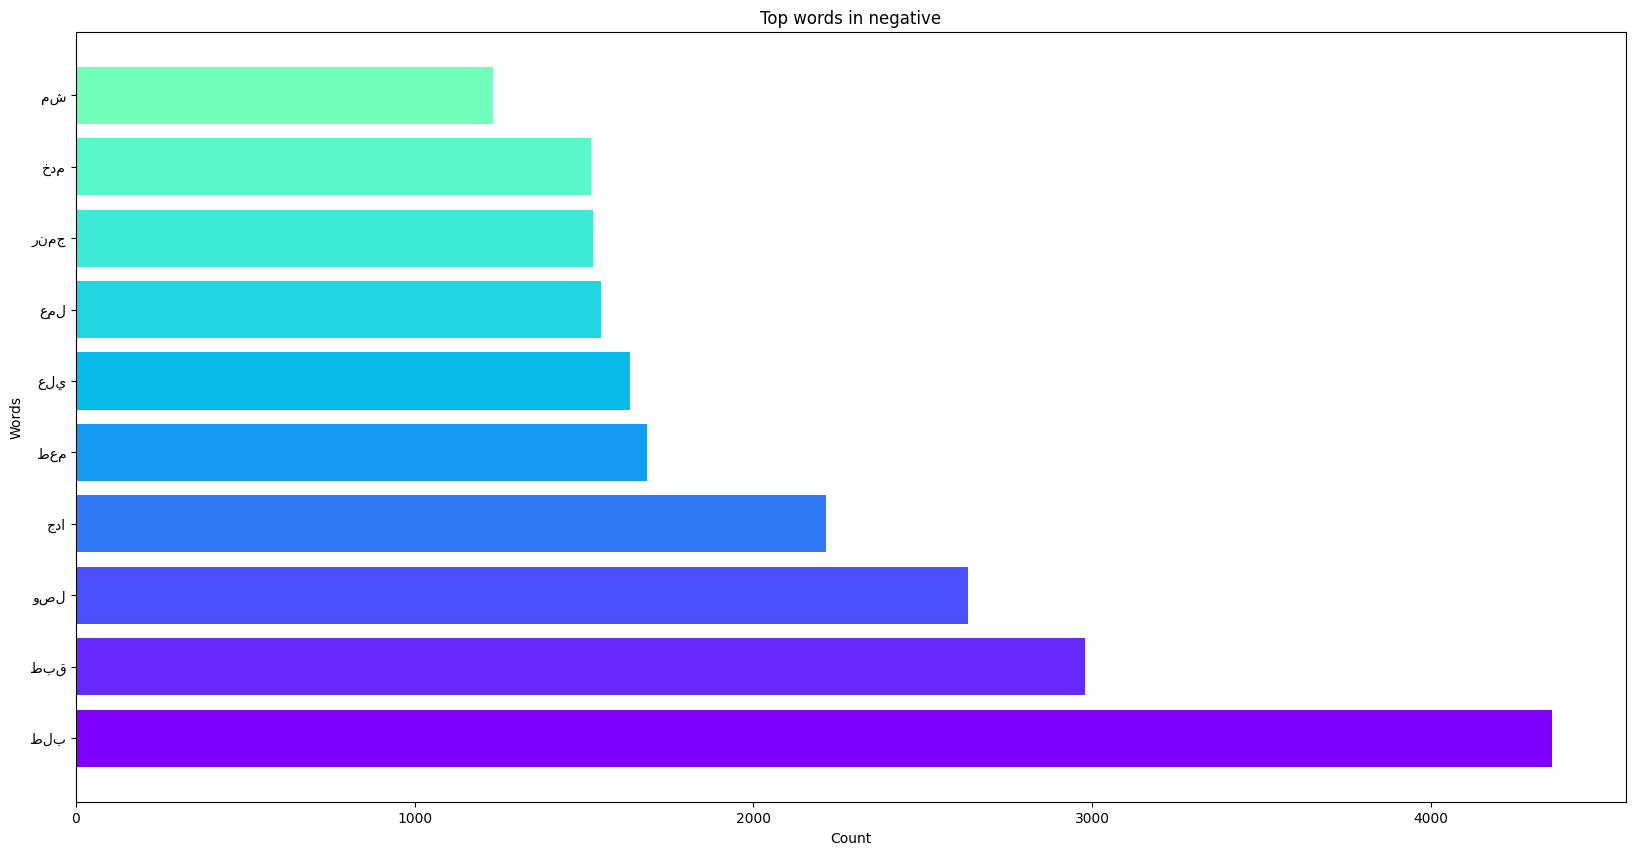

Total Words in TOTal 16803


In [4]:
pos = []
neg = []
neu = []

df[rating_col] = df[rating_col].replace({-1: 0, 0: 1, 1: 2})

for i in range(len(df[rating_col])) : 
    if df[rating_col][i] == 1:
        neu.append(df[review_col][i])

    if df[rating_col][i] == 2:
        pos.append(df[review_col][i])

    if df[rating_col][i] == 0:
        neg.append(df[review_col][i])



# Display the updated DataFrame Before
print(f"Length of 'positive' column Before: {len(pos)}")
print(f"Length of 'negative' column Before: {len(neg)}")
print(f"Length of 'neutral' column Before: {len(neu)}")


def display_stats(col,col_name):
    all_words = []

    for sentence in col :
        for word in sentence :
            all_words.append(word)

    VOCAB = sorted(list(set(all_words)))

    print(f"%s total words in {col_name}, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

    counter = Counter(all_words)
    counter.most_common(35)


    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 20))
    rcParams['figure.figsize'] = 20, 10

    plt.title('Top words in ' + col_name)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)
    plt.show()

    return len(VOCAB)



tot_words = 0
for col in [(pos,"positive"), (neu,"neutral"), (neg,"negative")]:
    tot_words += display_stats(col[0] ,col[1] )

print("Total Words in TOTal " + str(tot_words))

In [5]:
# Create new columns 'positive', 'negative', and 'neutral' based on the 'rating' column
# Identify the two minimum lengths
min_lengths = sorted([len(pos), len(neg), len(neu)])[:2]


num_duplicates = max(min_lengths) - len(neu)
duplicated_rows = df[df[rating_col] == 1].sample(n=num_duplicates, replace=True)
df = pd.concat([df, duplicated_rows], ignore_index=True)


# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the updated DataFrame After
print(f"Length of 'positive' column After: {len(df[df[rating_col]== 2])}")
print(f"Length of 'negative' column After: {len(df[df[rating_col] == 0])}")
print(f"Length of 'neutral' column After: {len(df[df[rating_col] == 1])}")

print(df.head(20))

Length of 'positive' column After: 19189
Length of 'negative' column After: 11340
Length of 'neutral' column After: 11340
                                   review_description  rating
0   [طبق, جيد, لكن, طلب, يتز, تخر, جدا, ولس, وصل, ...       1
1                                          [خلل, سعه]       2
2                 [صرح, انك, ترد, اكل, طلب, وبس, ﻷيك]       2
3                           [عجب, جدا, واستخدمه, اجع]       2
4   [طلب, كيلو, كفت, محل, صوف, ولم, يصل, كتب, علي,...       0
5             [غلي, وقل, شيء, طلب, 30, قدر, تلغ, طلب]       1
6                             [مش, حلو, خلص, زي, زفت]       0
7   [سمح, عيز, عرف, عدي, ميد, جزر, لاسكندريه, خلد,...       1
8   [شي, حلو, عند, لحظ, صغر, وقت, وصل, لزم, يكون, ...       2
9   [خط, سير, ظهر, عمل, خلل, طبق, خلف, خط, ظهر, لك...       1
10                         [اصبح, سيئ, تعب, فتح, طبق]       0
11                                   [رنمج, جدا, فيد]       2
12                                              [حله]       2
13        

In [6]:
for i in range(len(df[review_col])) :
    df[review_col][i] = ' '.join(df[review_col][i])
    


max_words = 5000 # top x most frequent words
max_len = 200 # max sentece len, it will truncate

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[review_col])
sequences = tokenizer.texts_to_sequences(df[review_col])
data = pad_sequences(sequences, maxlen=max_len)

y = np.array(df[rating_col])
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")


print(type(data))
print(f"rows : {len(data)} \n cols : {len(data[0])} \n")

/tmp/ipykernel_45430/1546499575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[review_col][i] = ' '.join(df[review_col][i])


<class 'numpy.ndarray'>
rows : 41869 
 cols : 200 



In [7]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))
model1.summary()


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# X_train, X_test, y_train, y_test = train_test_split(data,labels, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.3, random_state=42)

#y_test_one_hot = to_categorical(y_test, num_classes=3)
# y_train_one_hot = to_categorical(y_train, num_classes=3)

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)

history = model1.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test), callbacks=[checkpoint1])

2023-12-19 03:24:41.512839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 03:24:41.513188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 03:24:41.513364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 lstm (LSTM)                 (None, 15)                2160      
                                                                 
 dense (Dense)               (None, 3)                 48        
                                                                 
Total params: 102208 (399.25 KB)
Trainable params: 102208 (399.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/70


2023-12-19 03:24:45.407678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-19 03:24:45.455327: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d67a82f96e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 03:24:45.455357: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-12-19 03:24:45.466701: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702949085.557344   45552 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


393/393 [==============================] - ETA: 0s - loss: 0.9503 - accuracy: 0.5454
Epoch 1: val_accuracy improved from -inf to 0.58013, saving model to best_model1.hdf5
393/393 [==============================] - 28s 63ms/step - loss: 0.9503 - accuracy: 0.5454 - val_loss: 0.9446 - val_accuracy: 0.5801
Epoch 2/70
  1/393 [..............................] - ETA: 4s - loss: 0.6941 - accuracy: 0.6875

/home/hazem/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


393/393 [==============================] - ETA: 0s - loss: 0.7767 - accuracy: 0.6673
Epoch 2: val_accuracy improved from 0.58013 to 0.65509, saving model to best_model1.hdf5
393/393 [==============================] - 12s 31ms/step - loss: 0.7767 - accuracy: 0.6673 - val_loss: 0.7785 - val_accuracy: 0.6551
Epoch 3/70
393/393 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7175
Epoch 3: val_accuracy improved from 0.65509 to 0.70415, saving model to best_model1.hdf5
393/393 [==============================] - 11s 27ms/step - loss: 0.6828 - accuracy: 0.7175 - val_loss: 0.7041 - val_accuracy: 0.7042
Epoch 4/70
389/393 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.7397
Epoch 4: val_accuracy improved from 0.70415 to 0.72278, saving model to best_model1.hdf5
393/393 [==============================] - 10s 25ms/step - loss: 0.6406 - accuracy: 0.7398 - val_loss: 0.6827 - val_accuracy: 0.7228
Epoch 5/70
393/393 [==============================] - ETA